In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

## Preliminary Approach: CNN Baseline
---

Use a CNN by treating the problem as a classification task between 37 classes (0-36)

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor(14))


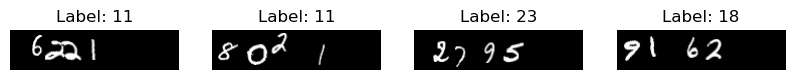

Batch 1:
  Input shape: torch.Size([32, 40, 168])
  Labels shape: torch.Size([32])


In [26]:
img_data_1 = np.load('data1.npy')
img_data_0 = np.load('data0.npy')
img_data_2 = np.load('data2.npy')

img_label1 = np.load('lab1.npy')
img_label0 = np.load('lab0.npy')
img_label2 = np.load('lab2.npy')

train_data = np.concatenate([img_data_0, img_data_1]) 
train_labels = np.concatenate([img_label0, img_label1])


# Convert numpy arrays to PyTorch tensors
train_data_tensor = torch.tensor(train_data, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
train_dataset = TensorDataset(train_data_tensor, train_labels_tensor)

# Combine the remaining data for the test dataset
test_data = img_data_2
test_labels = img_label2


# Create a DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Show some samples from the train_dataloader
data_iter = iter(train_dataloader)
images, labels = next(data_iter)

# Convert numpy arrays to PyTorch tensors
test_data_tensor = torch.tensor(test_data, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Create a TensorDataset
test_dataset = TensorDataset(test_data_tensor, test_labels_tensor)
print(test_dataset[3])

# Create a DataLoader
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Show some samples from the test_dataloader
test_data_iter = iter(test_dataloader)
test_images, test_labels = next(test_data_iter)

# Plot the first 4 images in the batch
fig, axes = plt.subplots(1, 4, figsize=(10, 2.5))
for i in range(4):
    ax = axes[i]
    ax.imshow(test_images[i].numpy().squeeze(), cmap='gray')
    ax.set_title(f'Label: {test_labels[i].item()}')
    ax.axis('off')
plt.show()
# Iterate through the DataLoader
for i, (inputs, labels) in enumerate(train_dataloader):
    print(f"Batch {i + 1}:")
    print(f"  Input shape: {inputs.shape}")
    print(f"  Labels shape: {labels.shape}")
    # Break after the first batch to limit output (optional)
    break



In [30]:
# Load data
img_data_1 = np.load('data1.npy')
img_data_0 = np.load('data0.npy')
img_data_2 = np.load('data2.npy')

img_label1 = np.load('lab1.npy')
img_label0 = np.load('lab0.npy')
img_label2 = np.load('lab2.npy')

# Concatenate training data and labels
train_data = np.concatenate([img_data_0, img_data_1])
train_labels = np.concatenate([img_label0, img_label0])  # Assuming img_label0 for img_data_0

# Add channel dimension and convert to PyTorch tensors
train_data_tensor = torch.tensor(train_data, dtype=torch.float32).unsqueeze(1)  # Shape: [20000, 1, 40, 168]
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)

# Create training dataset and dataloader
train_dataset = TensorDataset(train_data_tensor, train_labels_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [33]:
# Prepare test data
test_data = img_data_2
test_labels = img_label2

# Add channel dimension and convert to PyTorch tensors
test_data_tensor = torch.tensor(test_data, dtype=torch.float32).unsqueeze(1)  # Shape: [2000, 1, 40, 168]
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Create test dataset and dataloader
test_dataset = TensorDataset(test_data_tensor, test_labels_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Normalize image data if needed
# For example, if pixel values are in [0, 255], normalize to [0, 1]
train_data_tensor = train_data_tensor / 255.0
test_data_tensor = test_data_tensor / 255.0

In [32]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Third convolutional layer
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(in_features=64 * 5 * 21, out_features=512)
        self.relu_fc1 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=512, out_features=37)
    
    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        
        # Flatten the tensor for fully connected layers
        x = x.view(-1, 64 * 5 * 21)
        
        x = self.relu_fc1(self.fc1(x))
        x = self.fc2(x)
        return x
    

In [38]:
# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Instantiate the model, loss function, and optimizer
model = CNNClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 3

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (images, labels) in enumerate(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if (batch_idx + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_dataloader)}], Loss: {running_loss/100:.4f}')
            running_loss = 0.0

# Evaluation on test dataset
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on test set: {accuracy:.2f}%')

Using device: cuda
Epoch [1/3], Step [100/625], Loss: 4.4451
Epoch [1/3], Step [200/625], Loss: 3.1889
Epoch [1/3], Step [300/625], Loss: 3.2117
Epoch [1/3], Step [400/625], Loss: 3.1691
Epoch [1/3], Step [500/625], Loss: 3.1939
Epoch [1/3], Step [600/625], Loss: 3.1862
Epoch [2/3], Step [100/625], Loss: 3.1592
Epoch [2/3], Step [200/625], Loss: 3.1286
Epoch [2/3], Step [300/625], Loss: 3.1646
Epoch [2/3], Step [400/625], Loss: 3.1882
Epoch [2/3], Step [500/625], Loss: 3.1532
Epoch [2/3], Step [600/625], Loss: 3.1740
Epoch [3/3], Step [100/625], Loss: 3.0809
Epoch [3/3], Step [200/625], Loss: 3.0980
Epoch [3/3], Step [300/625], Loss: 3.1155
Epoch [3/3], Step [400/625], Loss: 3.0982
Epoch [3/3], Step [500/625], Loss: 3.1214
Epoch [3/3], Step [600/625], Loss: 3.1337
Accuracy on test set: 6.15%
